In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import time
import pickle

# cells defined in earlier notebooks

In [2]:
def R_nonbinding_3eq(y,t):
    """
    system of ODEs from Zaytsev 2016, simplified using two mass balances
    with the following components:
    - a: inactive Aurora B kinase
    - A: active Aurora B kinase
    - AA: enzyme-substrate complex of inactive + active Aurora B kinase
    - Ph: phosphatase
    - PhA: enzyme-substrate complex of phosphatase + active Aurora B kinase
    - a0: total Aurora B kinase
    - p0: total phosphatase
    """
    # set variable space
    A, AA, Ph = y
    
    # mass balances
    PhA = p0 - Ph
    a = a0 - A - 2*AA - PhA
    
    # reaction equations
    dAdt = (kcis - kfa*A)*a + (kra+2*kca)*AA - kfp*A*Ph + krp*PhA
    dAAdt = kfa*A*a - (kra+kca)*AA
    dPhdt = -kfp*A*Ph + (krp + kcp)*PhA
    
    return dAdt, dAAdt, dPhdt

In [3]:
"""
parameters from Zaytsev 2016
"""

kcis = 7.29*10**-6    # 1/s        # rate constant for 'in cis' Aurora B activation

kfa  = 0.1            # 1/(uM*s)   # rate constant for AA complex formation
kca  = 2.7*10**-2     # 1/s        # rate constant for AA catalysis
Kma  = 51             # uM         # Michaelis constant for AA 'in trans' activation
kra  = kfa*Kma-kca    # 1/         # rate constant for AA complex dissociation

kfp  = 0.6            # 1/(uM*s)   # rate constant for PhA complex formation
kcp  = 2.4*10**-2     # 1/s        # rate constant for PhA catalysis
Kmp  = 1.95           # uM         # Michaelis constant for PhA 'in trans' activation
krp  = kfp*Kmp-kcp    # 1/s        # rate constant for PhA complex dissociation

In [4]:
def R_nonbinding_3eq_cisonly(y,t):
    """
    system of ODEs from Zaytsev 2016, with the 'in trans' reaction component removed
    """
    # set variable space
    A, Ph = y
    
    # mass balances
    PhA = p0 - Ph
    a = a0 - A - PhA
    
    # reaction equations
    dAdt = kcis_only*a - kfp*A*Ph + krp*PhA
    dPhdt = -kfp*A*Ph + (krp + kcp)*PhA
    
    return dAdt, dPhdt

In [5]:
"""
parameter specific to the 'cis only' set of ODEs, fit to demonstrate principle
"""
kcis_only = 1.8*10**-3    # 1/s    # rate constant for 'in cis' Aurora B activation

# demonstration of bistability

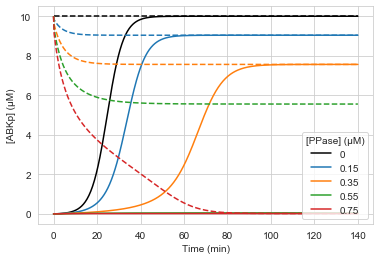

In [6]:
"""
Figure 5A
time evolution of the 'in cis + in trans' system showing bistability at 0.55 uM phosphatase where:
- an initially low state retains low activity
- an initially high state retains high activity
- this stability at two states does not exist for other phosphatase concentrations plotted
"""

a0 = 10
p0s = [0,.15,.35,.55,.75]
colors = ['k','C0','C1','C2','C3']
colors_dashed = ['k--','C0--','C1--','C2--','C3--']

t = np.linspace(0,140*60,500)

for p0,color,color_dashed in zip(p0s,colors,colors_dashed):

    # initially low activity
    y = odeint(R_nonbinding_3eq,[0,0,p0],t)
    plt.plot(t/60,y[:,0],color,label=f'{p0}')

    # initial high activity
    y = odeint(R_nonbinding_3eq,[a0,0,p0],t)
    plt.plot(t/60,y[:,0],color_dashed)

plt.legend(title='[PPase] (\u03BCM)',loc='lower right')
plt.xlabel("Time (min)")
plt.ylabel("[ABKp] (\u03BCM)");

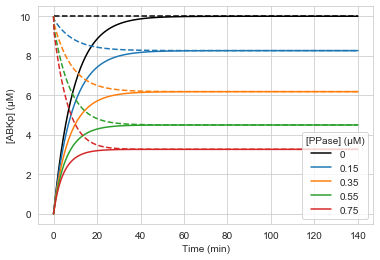

In [7]:
"""
Figure 5B
time evolution of the 'in cis' system showing no bistability
- thus, the 'in trans' reactions (positive feedback) are necessary for bistability
"""

a0 = 10
p0s = [0,.15,.35,.55,.75]
colors = ['k','C0','C1','C2','C3']
colors_dashed = ['k--','C0--','C1--','C2--','C3--']

t = np.linspace(0,140*60,500)

for p0,color,color_dashed in zip(p0s,colors,colors_dashed):

    y = odeint(R_nonbinding_3eq_cisonly,[0,p0],t)
    plt.plot(t/60,y[:,0],color,label=f'{p0}')

    y = odeint(R_nonbinding_3eq_cisonly,[a0,p0],t)
    plt.plot(t/60,y[:,0],color_dashed)

plt.legend(title='[PPase] (\u03BCM)',loc='lower right')
plt.xlabel("Time (min)")
plt.ylabel("[ABKp] (\u03BCM)");

In [8]:
def saddle_node_locator(ss_list):
    """
    find point where steady state (ss) jumps (hysteresis)
    where unsteady state manifold appears/disappears
    """
    for n,(i,j) in enumerate(zip(ss_list[:-1], ss_list[1:])):
        if abs(j-i) > 0.3:
            return n+1

In [9]:
"""
algorithm to find steady states + unsteady state manifold in the bistable regions
of the 'in cis + in trans' system at different phosphatase concentrations
"""
start = time.time()
## algorithm takes ~3 min

tspan = np.linspace(0,5000*60,10000)
Atot_range = np.arange(0,17.5,.05)

curves_15_75 = []

for p0 in [.15,.35,.55,.75]:

    lo_list = []
    hi_list = []
    Atot_bistable_list = []
    bistable_list = []

    for a0 in Atot_range:
        
        # time evolutions starting with low + high active kinase levels
        lo_init = [0,0,p0]
        y = odeint(R_nonbinding_3eq,lo_init,tspan)
        lo_ss = y[-1,0]
        lo_list.append(lo_ss)

        hi_init = [a0,0,p0]
        y = odeint(R_nonbinding_3eq,hi_init,tspan)
        hi_ss = y[-1,0]
        hi_list.append(hi_ss)
        
        # if steady state values differ with low + high initial active kinase levels,
        # system is bistable, record location along with both steady states
        if not np.isclose(lo_ss, hi_ss, atol=1):
            Atot_bistable_list.append(a0)
            bistable_list.append((a0, lo_ss, hi_ss))
    
    if len(bistable_list) == 0:
        # if no bistabiliy exists at this phosphatase concentration, record curve + move on
        curves_15_75.append((p0,lo_list,0,hi_list,0,0,0))
    else:
        # if bistability exists, time evolve at increasing kinase concentration
        # until steady state diverges, record point as unstable manifold
        unstablemanifold_list = []
        for a0, lo_ss, hi_ss in bistable_list:
            A0 = lo_ss
            y_sim = np.zeros((2,2))
            y_sim[-1,0] = -1
            while y_sim[-1,0] < np.average((A0,lo_ss)):
                A0 += .01
                A_init = [A0,0,p0]
                y_sim = odeint(R_nonbinding_3eq,A_init,tspan)
            unstablemanifold_list.append(A0)
        
        # finds hysteresis points in low and high steady state curves
        n_lo = saddle_node_locator(lo_list)
        n_hi = saddle_node_locator(hi_list)
        
        # plot low ss until hysteresis + unstable manifold + high ss from hysteresis
        saddle_x = [Atot_range[n_hi]] + Atot_bistable_list + [Atot_range[n_lo-1]]
        saddle_y = [hi_list[n_hi]] + unstablemanifold_list + [lo_list[n_lo-1]]

        curves_15_75.append((p0,lo_list,n_lo,hi_list,n_hi,saddle_x,saddle_y))

pickle.dump(curves_15_75,open('curves_15_75','wb'))

end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

~ 3.0 min


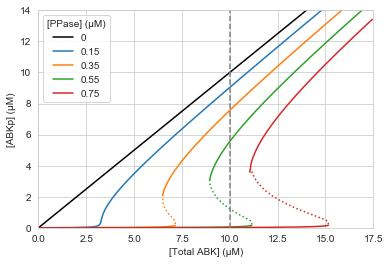

In [10]:
"""
Figure 5C
plots bistability curve results of above algorithm
dotted lines show the region of systems that are bistable
gray dashed line bisects the curves at values that correspond to the plot above, 
explaining the bistable behavior at 0.55 uM + monostable behavior otherwise
"""
curves_15_75 = pickle.load(open('curves_15_75','rb'))
Atot_range = np.arange(0,17.5,.05)

plt.plot(Atot_range,Atot_range,'k', label = '0')

p0,lo_list,n_lo,hi_list,n_hi,saddle_x,saddle_y = curves_15_75[0]
plt.plot(Atot_range,lo_list,'C0', label = '0.15')

p0,lo_list,n_lo,hi_list,n_hi,saddle_x,saddle_y = curves_15_75[1]
plt.plot(Atot_range[:n_lo], lo_list[:n_lo],'C1', label = '0.35')
plt.plot(Atot_range[n_hi:], hi_list[n_hi:],'C1')
plt.plot(saddle_x,saddle_y,'C1:')

p0,lo_list,n_lo,hi_list,n_hi,saddle_x,saddle_y = curves_15_75[2]
plt.plot(Atot_range[:n_lo], lo_list[:n_lo],'C2', label = '0.55')
plt.plot(Atot_range[n_hi:], hi_list[n_hi:],'C2')
plt.plot(saddle_x,saddle_y,'C2:')

p0,lo_list,n_lo,hi_list,n_hi,saddle_x,saddle_y = curves_15_75[3]
plt.plot(Atot_range[:n_lo], lo_list[:n_lo],'C3', label = '0.75')
plt.plot(Atot_range[n_hi:], hi_list[n_hi:],'C3')
# first three points not plotted due to imprecision in algorithm
plt.plot(saddle_x[3:],saddle_y[3:],'C3:')

# plot vertical line showing steady state values for 10 uM kinase, relating to previous two plots
plt.axvline(10,color='gray',linestyle='dashed')

plt.legend(title='[PPase] (\u03BCM)')
plt.xlabel('[Total ABK] (\u03BCM)')
plt.ylabel('[ABKp] (\u03BCM)')
plt.xlim(0,17.5)
plt.ylim(0,14)
plt.locator_params(axis='x', nbins=7);

In [11]:
"""
algorithm to find steady states
of the 'in cis' system at different phosphatase concentrations
"""
start = time.time()
## algorithm takes <1 min

tspan = np.linspace(0,5000*60,10000)
Atot_range = np.arange(0,17.5,.05)

curves_15_75_cis = []

for p0 in [.15,.35,.55,.75]:

    ss_list = []

    for a0 in Atot_range:

        init = [0,p0]
        y = odeint(R_nonbinding_3eq_cisonly,init,tspan)
        ss_list.append(y[-1,0])
    
    curves_15_75_cis.append((p0,ss_list,0,0,0,0,0))
    
end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

~ 0.4 min


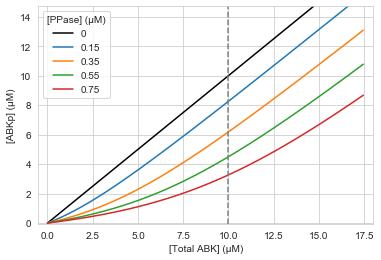

In [12]:
"""
Figure 5D
plots curves of the above algorithm showing no bistability
"""

colors = ['C0','C1','C2','C3']

plt.plot(Atot_range,Atot_range,'k', label = '0')

for (p0,lo_list,n_lo,hi_list,n_hi,saddle_x,saddle_y),color in zip(curves_15_75_cis,colors):
    plt.plot(Atot_range,lo_list, color, label = f'{p0}')

plt.axvline(10,color='gray',linestyle='dashed')

plt.legend(title='[PPase] (\u03BCM)')
plt.xlabel('[Total ABK] (\u03BCM)')
plt.ylabel('[ABKp] (\u03BCM)')
plt.xlim(-.5,18)
plt.ylim(-.05, 14*1.05);